In [1]:
# Cell 1: Imports & basic config
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import joblib

from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- CẤU HÌNH (chỉnh nếu cần) ---
BASE_DIR = "gtsrb"   # <-- đổi nếu thư mục của bạn khác
TRAIN_CSV = os.path.join(BASE_DIR, "Train.csv")
TEST_CSV  = os.path.join(BASE_DIR, "Test.csv")
META_CSV  = os.path.join(BASE_DIR, "Meta.csv")

IMG_SIZE = (32, 32)           # kích thước resize cho HOG
AUGMENT = False               # bật augmentation khi build features (True/False)
AUGMENT_FACTOR = 1            # nếu AUGMENT=True, mỗi ảnh sinh thêm bao nhiêu biến thể
SAMPLE_LIMIT = None           # để thử nhanh, đặt int (ví dụ 5000) hoặc None để dùng tất cả
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Cell 2: Robust CSV loader (thử nhiều separator) + load
def read_csv_guess(path, required_cols=("Path","ClassId")):
    tries = [",", "\t", ";", None]  # None để dùng engine='python' tự dò
    last_exception = None
    for sep in tries:
        try:
            if sep is None:
                df = pd.read_csv(path, engine="python")
            else:
                df = pd.read_csv(path, sep=sep)
            cols = set(df.columns.astype(str))
            if set(required_cols).issubset(cols):
                print(f"Loaded '{path}' with sep='{sep}' (columns ok)")
                return df
            else:
                # nếu thiếu cột Path/ClassId thì tiếp tục thử
                print(f"Tried sep='{sep}' but missing required cols -> {required_cols - cols}")
        except Exception as e:
            last_exception = e
    # fallback: đọc bằng read_csv mặc định
    print("Fallback reading (pandas default). Exception:", last_exception)
    df = pd.read_csv(path)
    return df

# Load CSVs
train_df = read_csv_guess(TRAIN_CSV, required_cols=("Path","ClassId"))
test_df  = read_csv_guess(TEST_CSV,  required_cols=("Path",))   # Test có thể không có ClassId
meta_df  = read_csv_guess(META_CSV,  required_cols=("Path","ClassId"))

# Quick view
print("\n--- Train head ---")
display(train_df.head())
print("\n--- Test head ---")
display(test_df.head())
print("\n--- Meta head ---")
display(meta_df.head())


Loaded 'gtsrb\Train.csv' with sep=',' (columns ok)
Loaded 'gtsrb\Test.csv' with sep=',' (columns ok)
Loaded 'gtsrb\Meta.csv' with sep=',' (columns ok)

--- Train head ---


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png



--- Test head ---


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png



--- Meta head ---


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


Train rows: 39209
Unique classes (train): 43


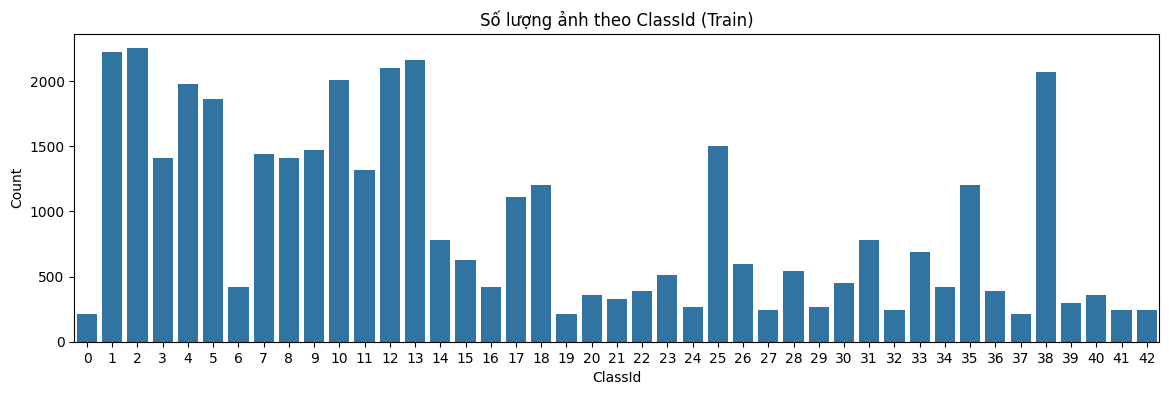

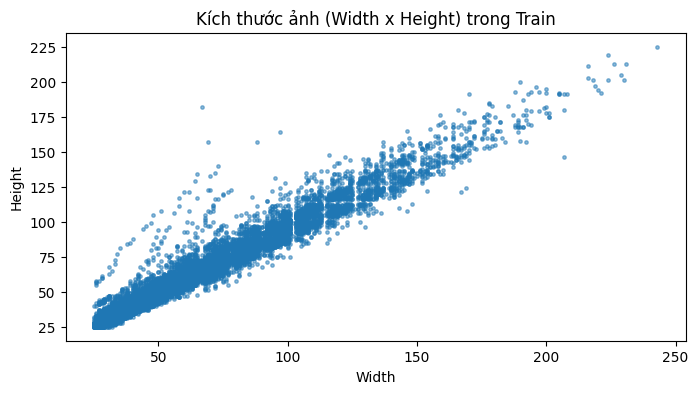

Width stats: {'count': 39209.0, 'mean': 50.83587951745773, 'std': 24.306933098419925, 'min': 25.0, '25%': 35.0, '50%': 43.0, '75%': 58.0, 'max': 243.0}
Height stats: {'count': 39209.0, 'mean': 50.328929582493814, 'std': 23.11542256888282, 'min': 25.0, '25%': 35.0, '50%': 43.0, '75%': 58.0, 'max': 225.0}


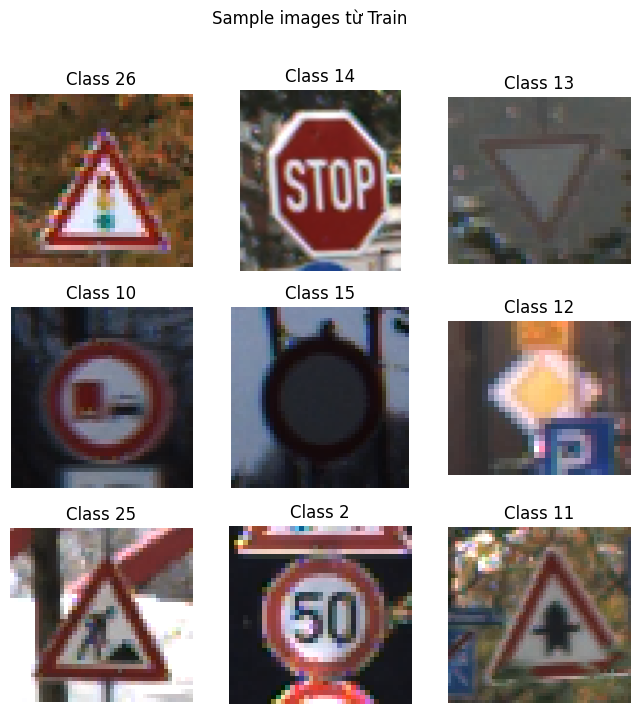

In [3]:
# Cell 3: EDA
print("Train rows:", len(train_df))
print("Unique classes (train):", train_df['ClassId'].nunique())

# phân phối nhãn
counts = train_df['ClassId'].value_counts().sort_index()
plt.figure(figsize=(14,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Số lượng ảnh theo ClassId (Train)")
plt.xlabel("ClassId")
plt.ylabel("Count")
plt.show()

# kích thước ảnh gốc (nếu có cột Width/Height)
if {'Width','Height'}.issubset(set(train_df.columns)):
    plt.figure(figsize=(8,4))
    plt.scatter(train_df['Width'], train_df['Height'], s=6, alpha=0.5)
    plt.title("Kích thước ảnh (Width x Height) trong Train")
    plt.xlabel("Width"); plt.ylabel("Height")
    plt.show()
    print("Width stats:", train_df['Width'].describe().to_dict())
    print("Height stats:", train_df['Height'].describe().to_dict())
else:
    print("Không tìm thấy cột Width/Height trong Train.csv để vẽ thống kê kích thước.")

# Show sample images: 9 random (nhiều class khác nhau khi có thể)
sample_rows = train_df.sample(9, random_state=RANDOM_STATE)
plt.figure(figsize=(8,8))
for i, (_, r) in enumerate(sample_rows.iterrows()):
    p = os.path.join(BASE_DIR, str(r['Path']).strip())
    img = cv2.imread(p)
    if img is None:
        display_text = f"Missing: {p}"
        ax = plt.subplot(3,3,i+1)
        ax.text(0.5,0.5,display_text,ha='center')
        ax.axis('off')
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"Class {int(r['ClassId'])}")
    plt.axis('off')
plt.suptitle("Sample images từ Train")
plt.show()


In [4]:
# Cell 4: Preprocessing utilities

def safe_int(x, default=0):
    try:
        return int(x)
    except:
        return default

def load_image_fullpath(path_rel):
    """Load image using BASE_DIR + relative path from CSV."""
    p = os.path.join(BASE_DIR, str(path_rel).strip())
    img = cv2.imread(p)
    if img is None:
        # thử path_rel như absolute nếu file đã là đường dẫn đầy đủ
        img = cv2.imread(str(path_rel).strip())
    return img

def crop_by_roi(img, row):
    """Crop using Roi.X1, Roi.Y1, Roi.X2, Roi.Y2 nếu có."""
    if img is None:
        return None
    cols = set(row.index.astype(str))
    if {'Roi.X1','Roi.Y1','Roi.X2','Roi.Y2'}.issubset(cols):
        x1 = safe_int(row['Roi.X1']); y1 = safe_int(row['Roi.Y1'])
        x2 = safe_int(row['Roi.X2']); y2 = safe_int(row['Roi.Y2'])
        # clamp
        h, w = img.shape[:2]
        x1, x2 = max(0,x1), min(w, x2)
        y1, y2 = max(0,y1), min(h, y2)
        if x2 > x1 and y2 > y1:
            return img[y1:y2, x1:x2]
    return img  # không crop nếu ko có ROI

def preprocess_for_hog(img, to_gray=True):
    """Resize, convert grayscale and optionally normalize if needed."""
    if img is None:
        return None
    if to_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    return img

# Augmentation (simple)
def random_flip(img):
    if np.random.rand() < 0.5:
        return cv2.flip(img, 1)  # horizontal flip
    return img

def random_rotation(img, max_angle=15):
    angle = np.random.uniform(-max_angle, max_angle)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

def random_brightness(img, limit=0.3):
    # img assumed grayscale or BGR uint8
    imgf = img.astype(np.float32)
    factor = 1.0 + np.random.uniform(-limit, limit)
    imgf *= factor
    imgf = np.clip(imgf, 0, 255).astype(np.uint8)
    return imgf

def augment_image(img):
    """Apply a random pipeline of augmentations."""
    out = img.copy()
    if np.random.rand() < 0.5:
        out = random_flip(out)
    if np.random.rand() < 0.5:
        out = random_rotation(out, max_angle=12)
    if np.random.rand() < 0.5:
        out = random_brightness(out, limit=0.25)
    return out


In [5]:
# Cell 5: HOG extractor and dataset->features builder
def compute_hog(image_gray):
    # image_gray: uint8 grayscale
    feats = hog(
        image_gray,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )
    return feats

def build_features_from_df(df, use_roi=True, augment=False, augment_factor=1, sample_limit=None, verbose=True):
    X = []
    y = []
    rows = df.itertuples(index=False)
    total = len(df) if sample_limit is None else min(len(df), sample_limit)
    it = df.head(sample_limit).iterrows() if sample_limit else df.iterrows()
    if verbose:
        it = tqdm(list(it), desc="Building features")
    for _, row in it:
        path = row['Path']
        img = load_image_fullpath(path)
        if img is None:
            # skip missing
            continue
        if use_roi:
            img = crop_by_roi(img, row)
        img = preprocess_for_hog(img, to_gray=True)
        if img is None:
            continue
        # original
        feats = compute_hog(img)
        X.append(feats)
        if 'ClassId' in row:
            y.append(int(row['ClassId']))
        else:
            y.append(None)
        # augmentations
        if augment:
            for k in range(augment_factor):
                aug_img = augment_image(img)
                feats_a = compute_hog(aug_img)
                X.append(feats_a)
                if 'ClassId' in row:
                    y.append(int(row['ClassId']))
                else:
                    y.append(None)
        # limit check
    X = np.array(X)
    y = np.array(y) if any(v is not None for v in y) else None
    if verbose:
        print("Built features:", X.shape, "labels:", None if y is None else y.shape)
    return X, y


In [6]:
# Cell 6: Build or load cached feature arrays
FEATURE_CACHE_X = os.path.join(BASE_DIR, "hog_X.npy")
FEATURE_CACHE_y = os.path.join(BASE_DIR, "hog_y.npy")

if os.path.exists(FEATURE_CACHE_X) and os.path.exists(FEATURE_CACHE_y):
    print("Loading cached features from disk...")
    X_all = np.load(FEATURE_CACHE_X)
    y_all = np.load(FEATURE_CACHE_y)
    print("Loaded shapes:", X_all.shape, y_all.shape)
else:
    print("Building features from Train.csv ... (this may take time)")
    X_all, y_all = build_features_from_df(
        train_df,
        use_roi=True,
        augment=AUGMENT,
        augment_factor=AUGMENT_FACTOR,
        sample_limit=SAMPLE_LIMIT,
        verbose=True
    )
    # save cache
    np.save(FEATURE_CACHE_X, X_all)
    np.save(FEATURE_CACHE_y, y_all)
    print("Saved feature cache to:", FEATURE_CACHE_X, FEATURE_CACHE_y)

# Sanity info
print("Feature vector length:", X_all.shape[1])
unique_classes, counts = np.unique(y_all, return_counts=True)
print("Classes found:", len(unique_classes))


Building features from Train.csv ... (this may take time)


Building features: 100%|██████████| 39209/39209 [00:59<00:00, 653.75it/s]


Built features: (39209, 324) labels: (39209,)
Saved feature cache to: gtsrb\hog_X.npy gtsrb\hog_y.npy
Feature vector length: 324
Classes found: 43


In [7]:
# Cell 7: Train/Validation split + KNN GridSearch (log time)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.20, random_state=RANDOM_STATE, stratify=y_all
)
print("Train/Val sizes:", X_train.shape[0], X_val.shape[0])

# Grid search K
param_grid = {"n_neighbors":[3,5,7,9]}
knn_base = KNeighborsClassifier(n_jobs=-1)

print("Starting GridSearchCV for KNN ...")
t0 = time.time()
grid = GridSearchCV(knn_base, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
t1 = time.time()
print(f"GridSearch done in {(t1-t0):.1f}s. Best params: {grid.best_params_}. Best CV score: {grid.best_score_:.4f}")

best_knn = grid.best_estimator_

# Save model
MODEL_PATH = os.path.join(BASE_DIR, "knn_hog_model.joblib")
joblib.dump(best_knn, MODEL_PATH)
print("Saved KNN model to:", MODEL_PATH)


Train/Val sizes: 31367 7842
Starting GridSearchCV for KNN ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearch done in 23.2s. Best params: {'n_neighbors': 5}. Best CV score: 0.9551
Saved KNN model to: gtsrb\knn_hog_model.joblib


Validation Accuracy: 0.9617444529456771

Classification report:

              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.90      0.87      0.88       444
           2       0.88      0.91      0.90       450
           3       0.97      0.95      0.96       282
           4       0.96      0.97      0.97       396
           5       0.82      0.83      0.83       372
           6       1.00      1.00      1.00        84
           7       0.90      0.91      0.91       288
           8       0.90      0.90      0.90       282
           9       0.98      1.00      0.99       294
          10       1.00      1.00      1.00       402
          11       0.94      0.96      0.95       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      0.99      0.99       156
          15       1.00      1.00      1.00       126
          16    

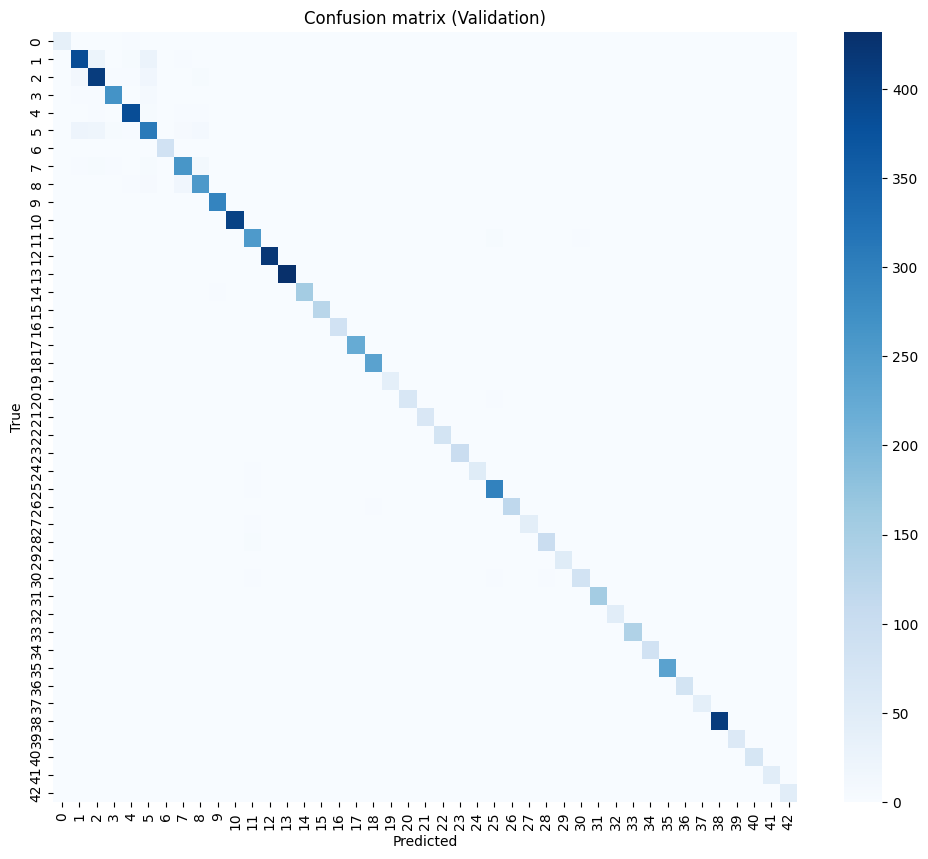

Số mẫu sai: 300


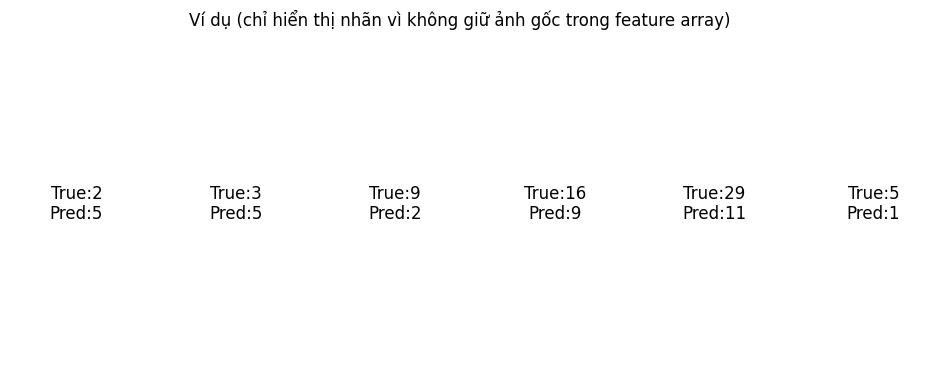

In [8]:
# Cell 8: Evaluate on validation set
y_pred = best_knn.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)
print("\nClassification report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

# Confusion matrix (vẽ)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.title("Confusion matrix (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Show some misclassified examples (lấy vài mẫu)
mis_idx = np.where(y_val != y_pred)[0]
print("Số mẫu sai:", len(mis_idx))
n_show = min(6, len(mis_idx))
if n_show>0:
    plt.figure(figsize=(12,4))
    for i in range(n_show):
        idx = mis_idx[i]
        feat = X_val[idx]
        true_label = y_val[idx]
        pred_label = y_pred[idx]
        # We don't retain original images in X arrays, so to show image we reload via train_df mapping:
        # find one row in train_df with matching ClassId and similar HOG? Simpler: we will skip reload here.
        plt.subplot(1,n_show,i+1)
        plt.text(0.5,0.5, f"True:{true_label}\nPred:{pred_label}", ha='center', va='center', fontsize=12)
        plt.axis('off')
    plt.suptitle("Ví dụ (chỉ hiển thị nhãn vì không giữ ảnh gốc trong feature array)")
    plt.show()
else:
    print("Không có ví dụ sai để hiển thị.")


Building HOG features for Test set...


Building features: 100%|██████████| 12630/12630 [00:17<00:00, 735.06it/s]


Built features: (12630, 324) labels: (12630,)
Test feature shape: (12630, 324)
Predicting ...
Predicted 12630 images in 2.6s
Saved submission to: gtsrb\submission_knn_hog.csv


,Path,Predicted_ClassId
0,Test/00000.png,16
1,Test/00001.png,1
2,Test/00002.png,38
3,Test/00003.png,33
4,Test/00004.png,11


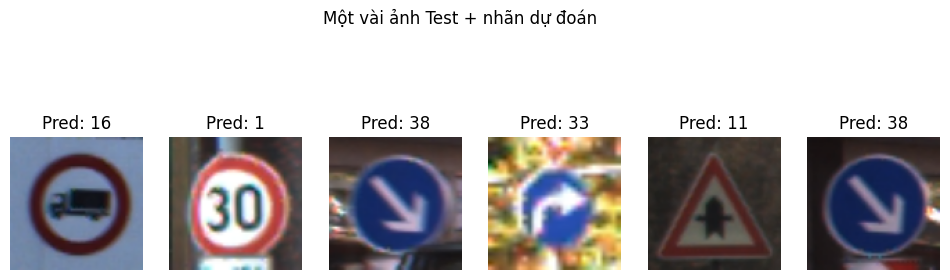

In [ ]:
# Cell 9: Predict on Test set and export
# Build features for Test (assume Test.csv has 'Path' and maybe ROI)
print("Building HOG features for Test set...")
X_test_feats, _ = build_features_from_df(test_df, use_roi=True, augment=False, augment_factor=0, sample_limit=None, verbose=True)
print("Test feature shape:", X_test_feats.shape)
a
print("Predicting ...")
t0 = time.time()
test_preds = best_knn.predict(X_test_feats)
t1 = time.time()
print(f"Predicted {len(test_preds)} images in {(t1-t0):.1f}s")

# Build submission with matched order to test_df rows that succeeded
# build_features_from_df preserves order of iterated rows but skipped missing images; we need to collect test_paths similarly.
test_paths = []
for _, row in test_df.iterrows():
    p = os.path.join(BASE_DIR, str(row['Path']).strip())
    if os.path.exists(p):
        test_paths.append(row['Path'])
    else:
        # check absolute path
        if os.path.exists(str(row['Path']).strip()):
            test_paths.append(row['Path'])
        else:
            # skip if missing
            pass

# If lengths mismatch, try to align by re-running small builder that returns paths
def build_test_features_with_paths(df):
    X = []
    paths = []
    for _, row in df.iterrows():
        img = load_image_fullpath(row['Path'])
        if img is None:
            continue
        img = crop_by_roi(img, row)
        img = preprocess_for_hog(img, to_gray=True)
        if img is None:
            continue
        feats = compute_hog(img)
        X.append(feats)
        paths.append(row['Path'])
    return np.array(X), paths

X_test_feats, test_paths = build_test_features_with_paths(test_df)
test_preds = best_knn.predict(X_test_feats)

submission = pd.DataFrame({"Path": test_paths, "Predicted_ClassId": test_preds})
out_csv = os.path.join(BASE_DIR, "submission_knn_hog.csv")
submission.to_csv(out_csv, index=False)
print("Saved submission to:", out_csv)
display(submission.head())

# show a few test images + predicted class
n_show = min(6, len(test_paths))
plt.figure(figsize=(12,4))
for i in range(n_show):
    p = os.path.join(BASE_DIR, str(test_paths[i]).strip())
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,n_show,i+1)
    plt.imshow(cv2.resize(img, (96,96)))
    plt.title(f"Pred: {test_preds[i]}")
    plt.axis('off')
plt.suptitle("Một vài ảnh Test + nhãn dự đoán")
plt.show()
